In [3]:
import os
import yaml
import pandas as pd
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

with open('db_default_profile.yaml') as fd:
    config = yaml.load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgres",
        host=config["host"],
        username=config["user"],
        database='hemank_joco',
        password=config["pass"],
        port=config["port"],
    )
    conn = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)


import RecallAdjuster as ra
from importlib import reload

import datetime
from dateutil.relativedelta import relativedelta
base = datetime.datetime.strptime('2018-04-01', '%Y-%m-%d')
date_pairs = []
for x in range(9,-1,-1):
    date_pairs.append(
        (
        (base - relativedelta(months=4*x) - relativedelta(years=1)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=4*x) - relativedelta(years=1)).strftime('%Y-%m-%d')
        )
    )
    date_pairs.append(
        (
        (base - relativedelta(months=4*x) - relativedelta(years=1)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=4*x)).strftime('%Y-%m-%d')
        )
    )

import seaborn as sns

In [4]:
date_pairs

[('2014-04-01', '2014-04-01'),
 ('2014-04-01', '2015-04-01'),
 ('2014-08-01', '2014-08-01'),
 ('2014-08-01', '2015-08-01'),
 ('2014-12-01', '2014-12-01'),
 ('2014-12-01', '2015-12-01'),
 ('2015-04-01', '2015-04-01'),
 ('2015-04-01', '2016-04-01'),
 ('2015-08-01', '2015-08-01'),
 ('2015-08-01', '2016-08-01'),
 ('2015-12-01', '2015-12-01'),
 ('2015-12-01', '2016-12-01'),
 ('2016-04-01', '2016-04-01'),
 ('2016-04-01', '2017-04-01'),
 ('2016-08-01', '2016-08-01'),
 ('2016-08-01', '2017-08-01'),
 ('2016-12-01', '2016-12-01'),
 ('2016-12-01', '2017-12-01'),
 ('2017-04-01', '2017-04-01'),
 ('2017-04-01', '2018-04-01')]

In [6]:
pd.read_sql('SELECT * FROM joco_bias_decoupled.tmp_bias_end_times', conn)

,past_train_end_time,future_train_end_time
0,2014-04-01,2014-04-01
1,2014-04-01,2015-04-01
2,2014-08-01,2014-08-01
3,2014-08-01,2015-08-01
4,2014-12-01,2014-12-01
5,2014-12-01,2015-12-01
6,2015-04-01,2015-04-01
7,2015-04-01,2016-04-01
8,2015-08-01,2015-08-01
9,2015-08-01,2016-08-01


In [7]:
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='rg_staff',
        schema='kit_bias_ablate',
        experiment_hashes='922b589d2ddd187665524dab017228c9',
        date_pairs=date_pairs,
        list_sizes=[500],
        #entity_demos='joco',
        entity_demos='hemank_bias_alternatives.currmatch_entity_demos',
        demo_col='race_2way',
        decoupled_experiments=[('7919a4a22d4ed46d199e9387b99bcffd', 'White'), ('48776f644a102217c57e2ca6724c614b', 'NonWhite')],
        decoupled_entity_demos='hemank_bias_alternatives.currmatch_entity_demos'
)

In [8]:
pd.read_sql("""
WITH best_mgs_rr AS (
  -- model_rank as the tie breker has the same potential issues as above, but may be amplified by the
  -- fact it's calculated across different models here. Also need to tie break beyond this since we
  -- could possible have ties across demos in that case, but there random should be fine since we'll
  -- be well-ordered within demo for calculating group-k, rolling precision, etc.
  SELECT *, ROW_NUMBER() OVER (PARTITION BY train_end_time ORDER BY score DESC, model_rank ASC, RANDOM()) AS rn_endtime_score
  FROM joco_bias_decoupled.tmp_bias_rolling_recall
  WHERE rn_mg_perf = 1
)
SELECT * FROM best_mgs_rr LIMIT 20
""", conn)


,entity_id,train_end_time,model_group_id,model_id,score,label_value,model_rank,demo_col,demo_value,rn_demo,num_demo_rolling,tp_demo_rolling,recall_demo_rolling,precision_demo_rolling,rn_recall,rn_mg_perf,rn_endtime_score
0,100412022,2014-04-01,65,1117,0.82831,1,13,race_2way,NonWhite,5,5,5,0.003876,1.000000,16,1,1
1,100135007,2014-04-01,65,1117,0.79510,1,24,race_2way,White,17,17,14,0.006645,0.823529,30,1,2
2,100378534,2014-04-01,65,1117,0.79428,0,25,race_2way,White,18,18,14,0.006645,0.777778,31,1,3
3,100056405,2014-04-01,128,20775,0.78540,1,16,race_2way,White,16,16,13,0.006170,0.812500,16,1,4
4,100237107,2014-04-01,110,20755,0.72644,1,15,race_2way,White,15,15,12,0.005695,0.800000,15,1,5
5,100098912,2014-04-01,205,22716,0.69345,1,6,race_2way,NonWhite,6,6,6,0.004651,1.000000,6,1,6
6,100119847,2014-04-01,205,22716,0.68051,1,9,race_2way,NonWhite,9,9,9,0.006977,1.000000,9,1,7
7,100370320,2014-04-01,156,21113,0.67447,1,5,race_2way,White,5,5,5,0.002373,1.000000,5,1,8
8,100351838,2014-04-01,98,1440,0.66903,1,14,race_2way,White,10,10,9,0.004271,0.900000,15,1,9
9,100370320,2014-04-01,157,21114,0.66311,1,6,race_2way,White,6,6,6,0.002848,1.000000,6,1,10


In [9]:
pd.read_sql("""
  SELECT *
  FROM joco_bias_decoupled.tmp_bias_rolling_recall
  WHERE model_id = 1117
  ORDER BY model_rank
  LIMIT 20
""", conn)

,entity_id,train_end_time,model_group_id,model_id,score,label_value,model_rank,demo_col,demo_value,rn_demo,num_demo_rolling,tp_demo_rolling,recall_demo_rolling,precision_demo_rolling,rn_recall,rn_mg_perf
0,100280453,2014-04-01,65,1117,0.87503,1,1,race_2way,White,1,1,1,0.000475,1.000000,1,19
1,100272416,2014-04-01,65,1117,0.86977,1,2,race_2way,White,2,2,2,0.000949,1.000000,3,35
2,100199311,2014-04-01,65,1117,0.85653,1,3,race_2way,White,3,3,3,0.001424,1.000000,4,11
3,100147057,2014-04-01,65,1117,0.85643,1,4,race_2way,NonWhite,1,1,1,0.000775,1.000000,2,13
4,100119847,2014-04-01,65,1117,0.85453,1,5,race_2way,NonWhite,2,2,2,0.001550,1.000000,5,21
5,100378843,2014-04-01,65,1117,0.85317,1,6,race_2way,White,4,4,4,0.001898,1.000000,6,35
6,100045843,2014-04-01,65,1117,0.85220,0,7,race_2way,White,5,5,4,0.001898,0.800000,7,37
7,100362237,2014-04-01,65,1117,0.85105,1,8,race_2way,White,6,6,5,0.002373,0.833333,9,32
8,100256050,2014-04-01,65,1117,0.85010,1,9,race_2way,NonWhite,3,3,3,0.002326,1.000000,8,19
9,100429080,2014-04-01,65,1117,0.84479,1,10,race_2way,NonWhite,4,4,4,0.003101,1.000000,11,19


- generate a series of score thresholds
- for each train_end_time / threshold / demo_col / demo_value combo, find the best model & # of people chosen
- for each train_end_time / threshold, calculate total # chosen across demos with best models
- pick highest threshold for each train_end_time that gives no more than desired list size

In [32]:
df = pd.read_sql("""
WITH all_end_times AS (
    SELECT DISTINCT past_train_end_time AS train_end_time FROM joco_bias_decoupled.tmp_bias_end_times
    UNION DISTINCT
    SELECT DISTINCT future_train_end_time AS train_end_time FROM joco_bias_decoupled.tmp_bias_end_times
)
, all_thresh AS (
  SELECT GENERATE_SERIES(0.5,1.0,0.1) AS thresh
)
, all_demo AS (
    SELECT distinct demo_col, demo_value FROM joco_bias_decoupled.tmp_bias_rolling_recall
)
, thresh_end_times AS (
    SELECT train_end_time, thresh, demo_col, demo_value
    FROM all_end_times
    CROSS JOIN all_thresh
    CROSS JOIN all_demo
)
, thresh_aggs AS (
    SELECT 
        tet.train_end_time,
        tet.thresh,
        tet.demo_col,
        tet.demo_value,
        rr.model_id,
        COUNT(*) AS num_demo_above_thresh,
        1.000*SUM(label_value)/NULLIF(COUNT(*), 0) AS demo_prec_above_thresh,
        MAX(rr.recall_demo_rolling) AS demo_recall_above_thresh
    FROM thresh_end_times tet
    LEFT JOIN joco_bias_decoupled.tmp_bias_rolling_recall rr
        ON tet.train_end_time = rr.train_end_time
        AND tet.demo_col = rr.demo_col
        AND tet.demo_value = rr.demo_value
        AND score >= thresh
    GROUP BY 1,2,3,4,5
)
, thresh_aggs_f1 AS (
    SELECT *, 2*(demo_prec_above_thresh*demo_recall_above_thresh) / NULLIF(demo_prec_above_thresh+demo_recall_above_thresh, 0) AS demo_f1_above_thresh
    FROM thresh_aggs
)
, thresh_aggs_rn AS (
    SELECT *, row_number() OVER (PARTITION BY train_end_time, thresh, demo_col, demo_value ORDER BY demo_f1_above_thresh DESC, RANDOM()) AS thresh_rn
    FROM thresh_aggs_f1
)
-- SELECT * FROM thresh_aggs_rn WHERE train_end_time = '2014-04-01' AND thresh = 0.5
SELECT train_end_time, thresh, SUM(num_demo_above_thresh) AS num_all_above_thresh
FROM thresh_aggs_rn
WHERE thresh_rn = 1
GROUP BY 1,2
ORDER BY 1,2
;

""", conn)

In [24]:
# total counts using precision for model choice
df.head(20)

,train_end_time,thresh,num_all_above_thresh
0,2014-04-01,0.5,14.0
1,2014-04-01,0.6,7.0
2,2014-04-01,0.7,4.0
3,2014-04-01,0.8,7.0
4,2014-04-01,0.9,18.0
5,2014-04-01,1.0,470.0
6,2014-08-01,0.5,12.0
7,2014-08-01,0.6,3.0
8,2014-08-01,0.7,2.0
9,2014-08-01,0.8,8.0


In [27]:
# example within-threshold ranking of models by precision
df.head(50)

,train_end_time,thresh,demo_col,demo_value,model_id,num_demo_above_thresh,demo_prec_above_thresh,thresh_rn
0,2014-04-01,0.5,race_2way,NonWhite,22701,2,1.000000,1
1,2014-04-01,0.5,race_2way,NonWhite,1422,2,1.000000,2
2,2014-04-01,0.5,race_2way,NonWhite,22700,8,0.875000,3
3,2014-04-01,0.5,race_2way,NonWhite,22698,11,0.818182,4
4,2014-04-01,0.5,race_2way,NonWhite,22699,8,0.750000,5
5,2014-04-01,0.5,race_2way,NonWhite,22703,7,0.714286,6
6,2014-04-01,0.5,race_2way,NonWhite,1432,52,0.711538,7
7,2014-04-01,0.5,race_2way,NonWhite,1434,62,0.709677,8
8,2014-04-01,0.5,race_2way,NonWhite,1439,42,0.690476,9
9,2014-04-01,0.5,race_2way,NonWhite,22714,32,0.687500,10


In [31]:
# example within-threshold ranking of models by F1 score
df.head(20)

,train_end_time,thresh,demo_col,demo_value,model_id,num_demo_above_thresh,demo_prec_above_thresh,demo_recall_above_thresh,demo_f1_above_thresh,thresh_rn
0,2014-04-01,0.5,race_2way,NonWhite,1103,4117,0.192859,0.615504,0.293693,1
1,2014-04-01,0.5,race_2way,NonWhite,22369,4117,0.192859,0.615504,0.293693,2
2,2014-04-01,0.5,race_2way,NonWhite,22366,1300,0.274615,0.276744,0.275676,3
3,2014-04-01,0.5,race_2way,NonWhite,1101,1300,0.274615,0.276744,0.275676,4
4,2014-04-01,0.5,race_2way,NonWhite,1099,4560,0.174561,0.617054,0.272137,5
5,2014-04-01,0.5,race_2way,NonWhite,22365,4560,0.174561,0.617054,0.272137,6
6,2014-04-01,0.5,race_2way,NonWhite,1106,738,0.334688,0.191473,0.243590,7
7,2014-04-01,0.5,race_2way,NonWhite,22362,738,0.334688,0.191473,0.243590,8
8,2014-04-01,0.5,race_2way,NonWhite,22387,541,0.380776,0.159690,0.225014,9
9,2014-04-01,0.5,race_2way,NonWhite,1121,411,0.450122,0.143411,0.217519,10


In [33]:
# total counts using F1 for model choice
df.head(20)

,train_end_time,thresh,num_all_above_thresh
0,2014-04-01,0.5,7764.0
1,2014-04-01,0.6,3648.0
2,2014-04-01,0.7,2.0
3,2014-04-01,0.8,4947.0
4,2014-04-01,0.9,4947.0
5,2014-04-01,1.0,1301.0
6,2014-08-01,0.5,7653.0
7,2014-08-01,0.6,7653.0
8,2014-08-01,0.7,3614.0
9,2014-08-01,0.8,4926.0


Ok, this approach seems to be a bit too problematic. It seems like to do this right, you'd really want to inspect all combinations of (model for group 1) x (model for group 2) x (threshold), figure out which ones yield a total of k entities, then among those somehow choose best models for each group/threshold combination and find the models/threshold combination that matches? I'm not too sure about either the within-group model choice criteria or an efficient way to explore that space...

Instead, we could make one of two simplifying assumptions:
- since the specific threshold isn't too clear, perhaps just choose the best models for each group based on AUC, combine, and take the top 500 from that (and hope that good AUC overall translates into good performace wherever the threshold ends up being)
- since we hope deviations from group sizes for the overall model will be relatively small, choose the best models based on performance at those group sizes (e.g., look at the top model overall, get the top k, see how many of each group are in it, then find the best models at those group-specific k points), then combine choose the top k from that composite and hope the group sizes are similar enough for the performance to not be too far off

The first is probably a bit more challenging to implement and the second at least reflects the top-k nature of the problem, so let's give it a shot...

In [45]:
df2 = pd.read_sql("""
WITH roll_prec AS (
    SELECT *,
        1.0000*(SUM(label_value) OVER (PARTITION BY model_id ORDER BY model_rank ASC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW))/model_rank AS precision_all_rolling
    FROM joco_bias_original.tmp_bias_rolling_recall
)
, overall_ranks AS (
    SELECT *, row_number () OVER (PARTITION BY train_end_time, model_rank ORDER BY precision_all_rolling DESC, RANDOM()) AS rn_precision_all
    FROM roll_prec
)
, best_overall AS (
    SELECT r.train_end_time, l.list_size, r.model_group_id, r.model_id
    FROM overall_ranks r
    JOIN joco_bias_original.tmp_bias_list_sizes l ON l.list_size = r.model_rank
    WHERE rn_precision_all = 1
)
, demo_counts AS (
    SELECT b.train_end_time, b.list_size, r.demo_col, r.demo_value, COUNT(*) AS num_demo
    FROM best_overall b
    JOIN joco_bias_original.tmp_bias_rolling_recall r
    ON b.train_end_time = r.train_end_time
        AND b.model_id = r.model_id
        AND r.model_rank <= b.list_size
    GROUP BY 1,2,3,4
)
, demo_model_ranks AS (
    SELECT dc.train_end_time, dc.list_size, dc.demo_col, dc.demo_value, dc.num_demo,
        r.model_group_id, r.model_id,
        row_number() OVER (PARTITION BY dc.train_end_time, dc.list_size, dc.demo_col, dc.demo_value, dc.num_demo ORDER BY precision_demo_rolling DESC, model_rank ASC, RANDOM()) AS rn_demo_num
    FROM demo_counts dc
    JOIN joco_bias_original.tmp_bias_rolling_recall r
        ON dc.train_end_time = r.train_end_time
        AND dc.demo_col = r.demo_col
        AND dc.demo_value = r.demo_value
        AND dc.num_demo = r.num_demo_rolling
)
, demo_best_models AS (
    SELECT * FROM demo_model_ranks WHERE rn_demo_num = 1
)
, composite_models AS (
    SELECT et.past_train_end_time, et.future_train_end_time AS train_end_time, 
        b.list_size, b.demo_col, b.demo_value, r.entity_id, r.score, r.label_value, r.recall_demo_rolling,
        row_number() OVER (PARTITION BY et.past_train_end_time, et.future_train_end_time, b.list_size ORDER BY r.score DESC, RANDOM()) AS rn_composite
    FROM demo_best_models b
    JOIN joco_bias_original.tmp_bias_end_times et
        ON b.train_end_time = et.past_train_end_time
    JOIN joco_bias_original.tmp_bias_rolling_recall r 
        ON r.train_end_time = et.future_train_end_time
        AND b.demo_col = r.demo_col
        AND b.demo_value = r.demo_value
        AND b.model_group_id = r.model_group_id
)
, composite_aggs AS (
    SELECT past_train_end_time, train_end_time, list_size, demo_col, demo_value, 
        COUNT(*) AS num_demo, 
        SUM(label_value) AS tp_demo,
        MAX(recall_demo_rolling) AS recall_demo
    FROM composite_models 
    WHERE rn_composite <= list_size
    GROUP BY 1,2,3,4,5
    ORDER BY 1,2,3,4,5
)
SELECT train_end_time, list_size, 
    SUM(num_demo) AS num_total,
    1.0000*SUM(tp_demo)/SUM(num_demo) AS precision_at_k,
    MAX(CASE WHEN demo_value = 'White' THEN recall_demo ELSE NULL END) / MAX(CASE WHEN demo_value = 'NonWhite' THEN recall_demo ELSE NULL END) AS recall_white_to_nonwhite,
    MAX(CASE WHEN demo_value = 'NonWhite' THEN recall_demo ELSE NULL END) / MAX(CASE WHEN demo_value = 'White' THEN recall_demo ELSE NULL END) AS recall_nonwhite_to_white
FROM composite_aggs
WHERE train_end_time > past_train_end_time
GROUP BY 1,2
ORDER BY 1,2
""", conn)


In [34]:
pd.read_sql('SELECT * FROM joco_bias_decoupled.tmp_bias_rolling_recall LIMIT 5', conn)

,entity_id,train_end_time,model_group_id,model_id,score,label_value,model_rank,demo_col,demo_value,rn_demo,num_demo_rolling,tp_demo_rolling,recall_demo_rolling,precision_demo_rolling,rn_recall,rn_mg_perf
0,100291338,2014-04-01,201,22712,0.65834,1,1,race_2way,NonWhite,1,1,1,0.000775,1.0,1,1
1,100083801,2014-04-01,76,1114,0.98393,1,2,race_2way,NonWhite,1,1,1,0.000775,1.0,2,2
2,100277041,2014-04-01,186,22387,1.00000,1,1,race_2way,NonWhite,1,1,1,0.000775,1.0,1,3
3,100256050,2014-04-01,184,22383,0.99855,1,1,race_2way,NonWhite,1,1,1,0.000775,1.0,1,4
4,100291338,2014-04-01,205,22716,0.73579,1,1,race_2way,NonWhite,1,1,1,0.000775,1.0,1,5


In [42]:
df

,train_end_time,list_size,num_total,precision_at_k,recall_white_to_nonwhite,recall_nonwhite_to_white
0,2014-04-01,500,500.0,0.532,3.265306,0.306250
1,2014-08-01,500,500.0,0.578,1.608750,0.621601
2,2014-12-01,500,500.0,0.578,2.247223,0.444994
3,2015-04-01,500,500.0,0.542,0.718541,1.391709
4,2015-08-01,500,500.0,0.540,6.546260,0.152759
5,2015-12-01,500,500.0,0.530,4.896150,0.204242
6,2016-04-01,500,500.0,0.600,1.327041,0.753556
7,2016-08-01,500,500.0,0.562,3.296414,0.303360
8,2016-12-01,500,500.0,0.552,0.821850,1.216766
9,2017-04-01,500,500.0,0.600,1.125904,0.888176


In [43]:
df['recall_white_to_nonwhite'].mean()

2.3117099782488606

In [44]:
df['precision_at_k'].mean()

0.5653846153846153

In [46]:
df2

,train_end_time,list_size,num_total,precision_at_k,recall_white_to_nonwhite,recall_nonwhite_to_white
0,2015-04-01,500,500.0,0.520,2.914790,0.343078
1,2015-08-01,500,500.0,0.556,1.637589,0.610654
2,2015-12-01,500,500.0,0.560,2.062079,0.484947
3,2016-04-01,500,500.0,0.552,1.080983,0.925084
4,2016-08-01,500,500.0,0.538,5.340045,0.187264
5,2016-12-01,500,500.0,0.518,8.104087,0.123395
6,2017-04-01,500,500.0,0.574,1.791325,0.558246
7,2017-08-01,500,500.0,0.584,3.242734,0.308382
8,2017-12-01,500,500.0,0.546,0.994051,1.005985
9,2018-04-01,500,500.0,0.558,1.202947,0.831292


In [47]:
df2['recall_white_to_nonwhite'].mean()

2.8370629456323893

In [48]:
df2['precision_at_k'].mean()

0.5506

(0.5, 3.5)

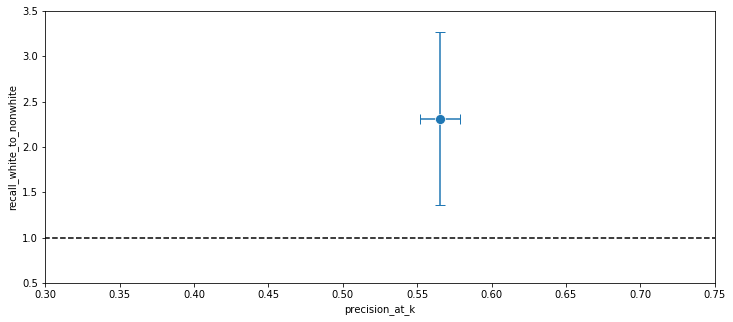

In [54]:
ts_df_1k = df.copy()
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df_1k.groupby(['list_size'])[['precision_at_k', 'recall_white_to_nonwhite']].mean().reset_index(), 
              x='precision_at_k', y='recall_white_to_nonwhite', 
#              hue='strategy',
#              hue='dataset', 
              marker="o", 
#              style='constraint_type',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


x_coords = list(ts_df_1k.groupby(['list_size'])[['precision_at_k', 'recall_white_to_nonwhite']].mean().reset_index()['precision_at_k'].values)
y_coords = list(ts_df_1k.groupby(['list_size'])[['precision_at_k', 'recall_white_to_nonwhite']].mean().reset_index()['recall_white_to_nonwhite'].values)
# labels = list(ts_df_1k.groupby(['list_size'])['strategy'].min())

prec_errors = 1.96*ts_df_1k.groupby(['list_size'])['precision_at_k'].sem().values
disp_errors = 1.96*ts_df_1k.groupby(['list_size'])['recall_white_to_nonwhite'].sem().values
colors = sns.color_palette().as_hex()[0]
ax.errorbar(x_coords, y_coords, 
            xerr=prec_errors, 
            yerr=disp_errors,
            ecolor=colors, 
            fmt=' ', zorder=-1, capsize=5)

ax.hlines(1.0, 0, 1, linestyles='dashed')

ax.set_xlim((0.3,0.75))
ax.set_ylim((0.5,3.50))
#ax.get_legend().remove()